In [0]:
# Importing libraries
import os
import cv2
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import models
from keras import backend as K
from keras.layers import Conv2D, MaxPool2D, Dropout, Activation, Dense, Flatten, BatchNormalization
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.preprocessing import image
from keras.metrics import categorical_crossentropy
from keras.layers.convolutional import *
from keras.applications import imagenet_utils
from keras.optimizers import adamax
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools
from keras.applications.mobilenet import MobileNet

In [0]:
# Loading images from folder
def images_from_folder(folder):
    images = []
    labels = []
    for file in os.listdir(folder):
        image = cv2.imread(os.path.join(folder,file))
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, 224, 224)
            images.append(image)
            labels.append(label)
    return images, labels

In [0]:
images_from_folder("/xray_data/covid")
images_from_folder("/xray_data/noncovid")


[array([[[58, 56, 59],
         [58, 56, 59],
         [58, 56, 59],
         ...,
         [58, 56, 59],
         [58, 56, 59],
         [60, 58, 61]],
 
        [[58, 56, 59],
         [58, 56, 59],
         [58, 56, 59],
         ...,
         [58, 56, 59],
         [58, 56, 59],
         [60, 58, 61]],
 
        [[58, 56, 59],
         [58, 56, 59],
         [58, 56, 59],
         ...,
         [58, 56, 59],
         [58, 56, 59],
         [60, 58, 61]],
 
        ...,
 
        [[58, 56, 59],
         [58, 56, 59],
         [58, 56, 59],
         ...,
         [58, 56, 59],
         [58, 56, 59],
         [60, 58, 61]],
 
        [[58, 56, 59],
         [58, 56, 59],
         [58, 56, 59],
         ...,
         [58, 56, 59],
         [58, 56, 59],
         [60, 58, 61]],
 
        [[58, 56, 59],
         [58, 56, 59],
         [58, 56, 59],
         ...,
         [58, 56, 59],
         [58, 56, 59],
         [60, 58, 61]]], dtype=uint8), array([[[68, 69, 71],
         [67, 68, 70

In [0]:
os.listdir("/".join(os.getcwd().split("/")[:-1] + ["xray_data","covid"]))

['nejmoa2001191_f5-PA.jpeg',
 'nejmc2001573_f1a.jpeg',
 'auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'ryct.2020200034.fig5-day4.jpeg',
 'lancet-case2a.jpg',
 'nCoV-radiol.2020200269.fig1-day7.jpeg',
 '1-s2.0-S0929664620300449-gr2_lrg-d.jpg',
 'lancet-case2b.jpg',
 'auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 '1-s2.0-S0929664620300449-gr2_lrg-a.jpg',
 'auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 '1-s2.0-S0929664620300449-gr2_lrg-b.jpg',
 '1-s2.0-S0929664620300449-gr2_lrg-c.jpg',
 'radiol.2020200490.fig3.jpeg',
 'ryct.2020200028.fig1a.jpeg',
 '1-s2.0-S0140673620303706-fx1_lrg.jpg',
 'nejmoa2001191_f3-PA.jpeg',
 'radiopedia-covid-19-pneumonia-2.jpg',
 'ryct.2020200034.fig5-day7.jpeg',
 'nejmoa2001191_f4.jpeg',
 'nejmc2001573_f1b.jpeg',
 'nejmoa2001191_f1-PA.jpeg',
 'ryct.2020200034.fig5-day0.jpeg',
 'auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'ryct.2020200034.fig2.jpeg'

In [0]:
covid_features, covid_labels = images_from_folder("/".join(os.getcwd().split("/")[:-1] + ["xray_data","covid"]),label=1)

In [0]:
len(covid_labels)

100

In [0]:
noncovid_features, noncovid_labels = images_from_folder("/".join(os.getcwd().split("/")[:-1] + ["xray_data","non_covid"]), label = 0)

In [0]:
len(noncovid_labels)

100

In [0]:
images = covid_features + noncovid_features
labels = covid_labels + noncovid_labels

In [0]:
data = np.asarray(images)
labels = np.asarray(labels)

In [0]:
def preprocess_input(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

In [0]:
data = preprocess_input(data)

In [0]:
labels = keras.utils.to_categorical(labels)

In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=42)

In [0]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [0]:
# Defining model
def mobilenet():
    model = keras.applications.mobilenet.MobileNet(include_top=False, weights= 'imagenet', input_shape= (224,224,3))
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    new_output = keras.layers.Dense(2, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [0]:
model = mobilenet()

In [0]:
len(model.layers)

84

In [0]:
for layer in model.layers[:75]:
        layer.trainable = False

In [0]:
# Compiling model
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.adamax(lr=1e-2),metrics=['accuracy'])

In [0]:
INIT_LR = 1e-3
EPOCHS = 15
BS = 24

In [0]:
len(trainX[0])

224

In [0]:
trainY

array([[[[  3,   3,   3],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  1,   1,   1],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  1,   1,   1],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [  1,   1,   1],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  1,   1,   1],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  4,   4,   4],
         ...,
         [  0,   0,   0],
        

In [0]:
history = model.fit_generator(data_generator.flow(trainX,trainY,24),
                        steps_per_epoch=len(trainX) / 24,
                        epochs = 15,
                        validation_data=(testX, testY),
                        validation_steps=len(testX) / 24,
                        verbose=1)

Epoch 1/15
7/6 [===============================] - 33s 5s/step - loss: 0.4152 - acc: 0.8503 - val_loss: 0.2731 - val_acc: 0.9500
Epoch 2/15
7/6 [===============================] - 27s 4s/step - loss: 0.1147 - acc: 0.9674 - val_loss: 0.0176 - val_acc: 1.0000
Epoch 3/15
7/6 [===============================] - 27s 4s/step - loss: 0.0250 - acc: 0.9940 - val_loss: 2.2529e-04 - val_acc: 1.0000
Epoch 4/15
7/6 [===============================] - 27s 4s/step - loss: 0.0570 - acc: 0.9734 - val_loss: 3.8552e-04 - val_acc: 1.0000
Epoch 5/15
7/6 [===============================] - 30s 4s/step - loss: 0.0127 - acc: 0.9914 - val_loss: 6.2345e-04 - val_acc: 1.0000
Epoch 6/15
7/6 [===============================] - 29s 4s/step - loss: 1.7647e-04 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 7/15
7/6 [===============================] - 26s 4s/step - loss: 0.0260 - acc: 0.9880 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 8/15
7/6 [===============================] - 24s 3s/step - loss: 0.0014 - a

In [0]:
# Model Evaluation
train_score = model.evaluate(trainX, trainY, verbose=0)
print(train_score)
test_score = model.evaluate(testX, testY,verbose=0)
print(test_score)

[0.1738748099654913, 0.925]
[0.08570775389671326, 0.975]


In [0]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=24)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=["covid", "noncovid"]))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        19
    noncovid       1.00      1.00      1.00        21

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



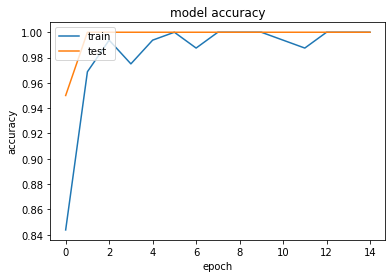

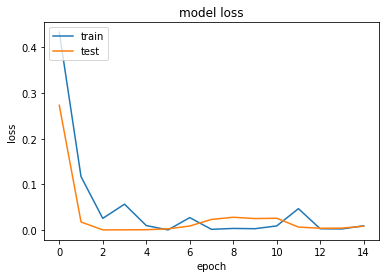

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save("/".join(os.getcwd().split("/")[:-1] + ["DLmodel/"])+"trainedmodel.h5")